# Train a model to generate structure of a piece (MELONS-inspired)

1. Read structure dataset from POP909_structure
2. Pre-process str into graph format
3. Setup transformer model
4. Train-val split, data loader
5. Evaluate model predictions

In [70]:
import torch
import os
import re

In [71]:
structure_path = "POP909_structure"

In [72]:
labels = []
label_paths = ["human_label1", "human_label2"]
for folder in os.listdir(structure_path):
    for label_path in label_paths:
        try:
            f = open(f"{structure_path}/{folder}/{label_path}.txt", "r")
            # print(f.read())
            labels.append(f.read())
        except:
            continue

In [73]:
labels[:5]

['i8A8A8B8C4C4b4b4x2A8B8C4C4C4C4X1o1\n',
 'i8A7A8B8C4C5b5b5A8B8C4C4C4C5o1\n',
 'i4A4A4B4B4C4C4C4D4x4B4B4C4C4C4D4X3\n',
 'i4A4A4B4B4C8C8x4B4B4C8C8X4\n',
 'i4A8A8B4C4b5x1b5A8B4x1C4C4\n']

In [74]:
def split_string(s):
    # This regex pattern matches a letter followed by one or more digits
    pattern = re.compile(r'[a-zA-Z]\d+')
    # Find all matches in the string
    matches = pattern.findall(s)
    return matches

In [75]:
split_string(labels[3])

['i4', 'A4', 'A4', 'B4', 'B4', 'C8', 'C8', 'x4', 'B4', 'B4', 'C8', 'C8', 'X4']

In [76]:
all_phrases = []
for label in labels:
    all_phrases.append(split_string(label))

In [77]:
all_phrases[:3]

[['i8',
  'A8',
  'A8',
  'B8',
  'C4',
  'C4',
  'b4',
  'b4',
  'x2',
  'A8',
  'B8',
  'C4',
  'C4',
  'C4',
  'C4',
  'X1',
  'o1'],
 ['i8',
  'A7',
  'A8',
  'B8',
  'C4',
  'C5',
  'b5',
  'b5',
  'A8',
  'B8',
  'C4',
  'C4',
  'C4',
  'C5',
  'o1'],
 ['i4',
  'A4',
  'A4',
  'B4',
  'B4',
  'C4',
  'C4',
  'C4',
  'D4',
  'x4',
  'B4',
  'B4',
  'C4',
  'C4',
  'C4',
  'D4',
  'X3']]

In [78]:
def get_phrase_edge_type(prev_phrase, curr_phrase, prev_phrase_idx, curr_phrase_idx):
    """
    Edge types:
    1: Intro to Any
    2: Any to Outro
    3: Repeated phrase
    4: Melody to Melody
    5: Melody to Non-Melody
    6: Non-Melody to Melody
    7: Non-Melody to Non-Melody
    """
    # print(prev_phrase_idx, curr_phrase_idx)
    
    prev_phrase_type = prev_phrase[0]
    curr_phrase_type = curr_phrase[0]
    
    if prev_phrase == curr_phrase:
            return 3
    
    if prev_phrase_idx + 1 == curr_phrase_idx:
        # print(prev_phrase_type)
    
        if prev_phrase_type == "i":
            return 1
        elif curr_phrase_type == "o":
            return 2
        elif prev_phrase_type.isupper() & curr_phrase_type.isupper():
            return 4
        elif prev_phrase_type.isupper() & curr_phrase_type.islower():
            return 5
        elif prev_phrase_type.islower() & curr_phrase_type.isupper():
            return 6
        elif prev_phrase_type.islower() & curr_phrase_type.islower():
            return 7
        else:
            return None

In [79]:
get_phrase_edge_type("A4", "B4", 1, 2)

4

In [80]:
all_phrases[0]

['i8',
 'A8',
 'A8',
 'B8',
 'C4',
 'C4',
 'b4',
 'b4',
 'x2',
 'A8',
 'B8',
 'C4',
 'C4',
 'C4',
 'C4',
 'X1',
 'o1']

In [81]:
# TODO: Get max size of phrases

In [82]:
def create_sequence(phrases):
    # Create sequence of edges from phrase, where each item is a tuple (i, j, edge type, num bars in i, num bars in j)
    # Start seq with START token
    seq = [(40, 40, 8, 10, 10)]
    max_phrase_len = 0
    for i, phrase_from in enumerate(phrases):
        for j, phrase_to in enumerate(phrases[i+1:]):
            phrase_to_idx = j+i+1
            edge_type = get_phrase_edge_type(phrase_from, phrase_to, i, phrase_to_idx)
            if edge_type is not None:
                phrase_from_len = int(phrase_from[1])
                phrase_to_len = int(phrase_to[1])
                max_phrase_len = max(max_phrase_len, max(phrase_from_len, phrase_to_len))
                seq.append((i+1, phrase_to_idx+1, edge_type, phrase_from_len, phrase_to_len))
    
    # Append END token
    seq.append((41, 41, 9, 11, 11))
    return seq, max_phrase_len

In [83]:
seqs = []
max_phrase_len = 0
max_num_nodes = 0
for phrases in all_phrases:
    # print(phrases)
    num_nodes = len(phrases)
    seq, max_phrase_len_indiv = create_sequence(phrases)
    seqs.append(seq)
    max_phrase_len = max(max_phrase_len, max_phrase_len_indiv)
    max_num_nodes = max(max_num_nodes, num_nodes)

In [84]:
all_phrases[1]

['i8',
 'A7',
 'A8',
 'B8',
 'C4',
 'C5',
 'b5',
 'b5',
 'A8',
 'B8',
 'C4',
 'C4',
 'C4',
 'C5',
 'o1']

In [85]:
seqs[1]

[(40, 40, 8, 10, 10),
 (1, 2, 1, 8, 7),
 (2, 3, 4, 7, 8),
 (3, 4, 4, 8, 8),
 (3, 9, 3, 8, 8),
 (4, 5, 4, 8, 4),
 (4, 10, 3, 8, 8),
 (5, 6, 4, 4, 5),
 (5, 11, 3, 4, 4),
 (5, 12, 3, 4, 4),
 (5, 13, 3, 4, 4),
 (6, 7, 5, 5, 5),
 (6, 14, 3, 5, 5),
 (7, 8, 3, 5, 5),
 (8, 9, 6, 5, 8),
 (9, 10, 4, 8, 8),
 (10, 11, 4, 8, 4),
 (11, 12, 3, 4, 4),
 (11, 13, 3, 4, 4),
 (12, 13, 3, 4, 4),
 (13, 14, 4, 4, 5),
 (14, 15, 2, 5, 1),
 (41, 41, 9, 11, 11)]

In [86]:
max_phrase_len

9

In [87]:
max_num_nodes

39

In [88]:
len(seqs[2])

34

## Dataloader

In [89]:
import torch
from torch.nn.utils.rnn import pad_sequence

def sequences_to_tensor(sequences, padding_value=0):
    """
    Convert a list of sequences of different lengths to a padded tensor.

    Args:
        sequences (list of list of tuples): List of sequences where each sequence is a list of tuples.
        padding_value (int, optional): Value to use for padding. Defaults to 0.

    Returns:
        torch.Tensor: Padded tensor of shape (batch_size, max_length, tuple_length)
    """
    # Convert each sequence to a tensor
    tensor_sequences = [torch.tensor(seq) for seq in sequences]

    # Pad sequences to the length of the longest sequence
    padded_sequences = pad_sequence(tensor_sequences, batch_first=True, padding_value=padding_value)

    return padded_sequences


In [90]:
len(seqs)

1818

In [91]:
padded_seq = sequences_to_tensor(seqs, padding_value=0)
print("Padded seq shape:", padded_seq.shape)

Padded seq shape: torch.Size([1818, 152, 5])


In [92]:
from torch.utils.data import Dataset, DataLoader, random_split

In [93]:
# Train-test split
test_ratio = 0.1

num_test = round(len(seqs) * test_ratio)
train_split, test_split = random_split(padded_seq, [len(seqs)-num_test, num_test])
print(f"Split data into Train and Test sets of size {len(train_split)} and {len(test_split)} respectively.")

Split data into Train and Test sets of size 1636 and 182 respectively.


In [94]:
# Define the custom dataset
class TupleSequenceDataset(Dataset):
    def __init__(self, input_sequences, output_sequences):
        self.input_sequences = input_sequences
        self.output_sequences = output_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return [self.input_sequences[idx], self.output_sequences[idx]]

# Parameters
batch_size = 32
shuffle = True

# Create the dataset
dataset_train = TupleSequenceDataset(train_split, train_split)
dataset_test = TupleSequenceDataset(test_split, test_split)

# Create the DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=shuffle)


In [95]:
n_token = [max_num_nodes+4, max_num_nodes+4, 10, max_phrase_len+3, max_phrase_len+3]
# +1 to all to account for indices
# +1 to max_num_nodes to account for START/END/PAD tokens
# n_token[2] = 7+3 to account for START/END/PAD tokens

In [96]:
n_token

[43, 43, 10, 12, 12]

## Autoregression transformer

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math
from tqdm import tqdm

In [98]:
# Ref: https://github.com/YatingMusic/compound-word-transformer/blob/main/workspace/uncond/cp-linear/main-cp.py
# https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
# https://gist.github.com/danimelchor/bcad4d7f79b98464c4d4481d62d27622

class Embeddings(nn.Module):
    """
    Get embeddings for edge tokens
    """
    def __init__(self, n_token, d_model):
        super(Embeddings, self).__init__()
        # print(n_token)
        self.lut = nn.Embedding(n_token, d_model, padding_idx=0)
        self.d_model = d_model

    def forward(self, x):
        # print(n_token)
        # print(x.shape)
        # print(torch.max(x))
        # print(torch.min(x))
        # print(self.d_model)
        # print(self.lut(x))
        return self.lut(x) * math.sqrt(self.d_model)
    
    
class PositionalEncoding(nn.Module):
    """
    Get positional encodings
    """
    def __init__(self, d_model, dropout=0.1, max_len=20000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
        


class AutoregressiveTransformer(nn.Module):
    def __init__(self, n_token):
        super(AutoregressiveTransformer, self).__init__()
        
        # --- params config --- #
        self.n_token = n_token   
        self.d_model = D_MODEL 
        self.d_feedforward = D_FEEDFW
        self.n_layer = N_LAYER
        self.dropout = 0.1
        self.n_head = N_HEAD
        self.d_head = D_MODEL // N_HEAD
        self.d_inner = 1024
        # self.loss_func = nn.CrossEntropyLoss(reduction='none')
        self.emb_sizes = [128, 128, 12, 16, 16]
        
        
        # --- modules config --- #
        # embeddings
        print('>>>>>:', self.n_token)
        self.emb_i = Embeddings(self.n_token[0], self.emb_sizes[0])
        self.emb_j = Embeddings(self.n_token[1], self.emb_sizes[1])
        self.emb_edge_type = Embeddings(self.n_token[2], self.emb_sizes[2])
        self.emb_i_size = Embeddings(self.n_token[3], self.emb_sizes[3])
        self.emb_j_size = Embeddings(self.n_token[4], self.emb_sizes[4])
        self.pos_emb = PositionalEncoding(self.d_model, self.dropout)

        # linear 
        self.in_linear = nn.Linear(np.sum(self.emb_sizes), self.d_model)
        
        # encoder
        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.n_head,
            num_encoder_layers=self.n_layer,
            num_decoder_layers=self.n_layer,
            dim_feedforward=self.d_feedforward,
            dropout=self.dropout,
        )

        # individual output
        self.proj_i    = nn.Linear(self.d_model, self.n_token[0])        
        self.proj_j    = nn.Linear(self.d_model, self.n_token[1])
        self.proj_edge_type  = nn.Linear(self.d_model, self.n_token[2])
        self.proj_i_size     = nn.Linear(self.d_model, self.n_token[3])
        self.proj_j_size    = nn.Linear(self.d_model, self.n_token[4])
    
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        '''
        linear transformer: b x s x f
        x.shape=(bs, nf)
        '''
        
        # print(f"src shape: {src.shape}, target shape: {tgt.shape}")
    
        # src embeddings
        emb_i_src =    self.emb_i(src[..., 0])
        emb_j_src =    self.emb_j(src[..., 1])
        emb_edge_type_src =  self.emb_edge_type(src[..., 2])
        emb_i_size_src =     self.emb_i_size(src[..., 3])
        emb_j_size_src =    self.emb_j_size(src[..., 4])

        embs_src = torch.cat(
            [
                emb_i_src,
                emb_j_src,
                emb_edge_type_src,
                emb_i_size_src,
                emb_j_size_src,
            ], dim=-1)

        emb_linear_src = self.in_linear(embs_src)
        pos_emb_src = self.pos_emb(emb_linear_src)
        
        
        # tgt embeddings
        emb_i_tgt =    self.emb_i(tgt[..., 0])
        emb_j_tgt =    self.emb_j(tgt[..., 1])
        emb_edge_type_tgt =  self.emb_edge_type(tgt[..., 2])
        emb_i_size_tgt =     self.emb_i_size(tgt[..., 3])
        emb_j_size_tgt =    self.emb_j_size(tgt[..., 4])

        embs_tgt = torch.cat(
            [
                emb_i_tgt,
                emb_j_tgt,
                emb_edge_type_tgt,
                emb_i_size_tgt,
                emb_j_size_tgt,
            ], dim=-1)

        emb_linear_tgt = self.in_linear(embs_tgt)
        pos_emb_tgt = self.pos_emb(emb_linear_tgt)
        
        # target embeddings
    
        # transformer
        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        # print(pos_emb_src.shape)
        # print(pos_emb_tgt.shape)
        pos_emb_src = pos_emb_src.permute(1,0,2)
        pos_emb_tgt = pos_emb_tgt.permute(1,0,2)
        # print(f"Transformer input dim: {pos_emb_src.shape}, target dim: {pos_emb_tgt.shape}")
        transformer_out = self.transformer(pos_emb_src, pos_emb_tgt, 
                                           tgt_mask=tgt_mask, 
                                           src_key_padding_mask=src_pad_mask, 
                                           tgt_key_padding_mask=tgt_pad_mask)
        # print(f"Transformer output dim: {transformer_out.shape}")
        

        y_i    = self.proj_i(transformer_out)
        y_j    = self.proj_j(transformer_out)
        y_edge_type  = self.proj_edge_type(transformer_out)
        y_i_size    = self.proj_i_size(transformer_out)
        y_j_size = self.proj_j_size(transformer_out)

        return  y_i, y_j, y_edge_type, y_i_size, y_j_size
    
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a square matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)
        



In [99]:
def compute_loss(predict, target, loss_func, loss_mask):
        # predict = predict.permute(1, 2, 0)  
        predict = predict.permute(2, 1, 0)  
        # print(torch.min(target))
        # print(torch.max(target))
        # print(f"Predict shape: {predict}, Target shape: {target}")
        loss = loss_func(predict, target)
        # print(f"Initial loss shape: {loss.shape}")
        # print(f"Initial loss: {loss}")
        # loss = loss * loss_mask
        # loss = torch.sum(loss) / torch.sum(loss_mask)
        return loss.sum()

In [100]:
def train_loop(model, opt, loss_fn, dataloader):
    
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in dataloader:
        X = batch_X.to(device)
        y = batch_y.to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        # Get mask to mask out the next words
        # print(f"X shape: {X.shape}")
        # print(f"y_input shape: {y_input.shape}")

        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)
        # print(f"mask shape: {tgt_mask.shape}")        
        
        y_i, y_j, y_edge_type, y_i_size, y_j_size = model(X, y_input, tgt_mask)
        
        # print(f"shape after model pred: {y_i.shape}, {y_j.shape}")

        # reshape (b, s, f) -> (b, f, s)
        y_i = y_i[:, ...].permute(0, 2, 1)
        y_j = y_j[:, ...].permute(0, 2, 1)
        y_edge_type = y_edge_type[:, ...].permute(0, 2, 1)
        y_i_size = y_i_size[:, ...].permute(0, 2, 1)
        y_j_size = y_j_size[:, ...].permute(0, 2, 1)
        
        # print(f"shape after reshape: {y_i.shape}, {y_j.shape}")
        # print(f"y_expected shape: {y_expected.shape}, y_expected_i: {y_expected[..., 0].shape}")

        # loss
        loss_i = compute_loss(
                y_i, y_expected[..., 0], loss_fn, tgt_mask)
        loss_j = compute_loss(
                y_j, y_expected[..., 1], loss_fn, tgt_mask)
        loss_edge_type = compute_loss(
                y_edge_type, y_expected[..., 2], loss_fn, tgt_mask)
        loss_i_size = compute_loss(
                y_i_size,  y_expected[..., 3], loss_fn, tgt_mask)
        loss_j_size = compute_loss(
                y_j_size, y_expected[..., 4], loss_fn, tgt_mask)

        loss = (loss_i + loss_j + loss_edge_type + loss_i_size + loss_j_size) / 5
        print(f"Loss: {loss:.2f} | loss_i: {loss_i:.2f} loss_j: {loss_j:.2f} loss_edge_type: {loss_edge_type:.2f} loss_i_size: {loss_i_size:.2f} loss_j_size: {loss_j_size:.2f}")
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            
            X = batch_X.to(device)
            y = batch_y.to(device)


            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)
            
            
            y_i, y_j, y_edge_type, y_i_size, y_j_size = model(X, y_input, tgt_mask)

            # reshape (b, s, f) -> (b, f, s)
            y_i = y_i[:, ...].permute(0, 2, 1)
            y_j = y_j[:, ...].permute(0, 2, 1)
            y_edge_type = y_edge_type[:, ...].permute(0, 2, 1)
            y_i_size = y_i_size[:, ...].permute(0, 2, 1)
            y_j_size = y_j_size[:, ...].permute(0, 2, 1)
            

            # loss
            loss_i = compute_loss(
                    y_i, y_expected[..., 0], loss_fn, tgt_mask)
            loss_j = compute_loss(
                    y_j, y_expected[..., 1], loss_fn, tgt_mask)
            loss_edge_type = compute_loss(
                    y_edge_type, y_expected[..., 2], loss_fn, tgt_mask)
            loss_i_size = compute_loss(
                    y_i_size,  y_expected[..., 3], loss_fn, tgt_mask)
            loss_j_size = compute_loss(
                    y_j_size, y_expected[..., 4], loss_fn, tgt_mask)

            loss = (loss_i + loss_j + loss_edge_type + loss_i_size + loss_j_size) / 5
            print(f"Validation Loss: {loss:.2f} | loss_i: {loss_i:.2f} loss_j: {loss_j:.2f} loss_edge_type: {loss_edge_type:.2f} loss_i_size: {loss_i_size:.2f} loss_j_size: {loss_j_size:.2f}")

            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

In [101]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in tqdm(range(epochs)):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list


In [102]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [103]:
n_token

[43, 43, 10, 12, 12]

In [104]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using device: {device}")

# Hyperparameters
N_LAYER = 4
N_HEAD = 4
D_MODEL = 256
D_FEEDFW = 1024

learning_rate = 1e-4

# Initialize the model, optimizer, and loss function
model = AutoregressiveTransformer(n_token).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(reduction='none')

train_loss_list, validation_loss_list = fit(model, optimizer, loss_fn, dataloader_train, dataloader_test, 20)

Using device: cuda
>>>>>: [43, 43, 10, 12, 12]
Training and validating model


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------- Epoch 1 -------------------------
Loss: 13744.65 | loss_i: 17835.79 loss_j: 17851.54 loss_edge_type: 10889.70 loss_i_size: 11724.36 loss_j_size: 10421.84
Loss: 9111.38 | loss_i: 12914.35 loss_j: 14085.17 loss_edge_type: 5856.33 loss_i_size: 7045.30 loss_j_size: 5655.78
Loss: 6970.24 | loss_i: 8855.09 loss_j: 11506.82 loss_edge_type: 4410.18 loss_i_size: 5550.74 loss_j_size: 4528.37
Loss: 6284.02 | loss_i: 7062.00 loss_j: 9822.59 loss_edge_type: 4448.77 loss_i_size: 5456.15 loss_j_size: 4630.57
Loss: 5593.20 | loss_i: 6038.51 loss_j: 8130.25 loss_edge_type: 4265.32 loss_i_size: 5065.07 loss_j_size: 4466.84
Loss: 5258.57 | loss_i: 5762.73 loss_j: 7076.85 loss_edge_type: 4174.51 loss_i_size: 4878.73 loss_j_size: 4400.03
Loss: 4918.01 | loss_i: 5503.80 loss_j: 6207.09 loss_edge_type: 4015.28 loss_i_size: 4621.25 loss_j_size: 4242.60
Loss: 5029.06 | loss_i: 5908.73 loss_j: 6136.78 loss_edge_type: 4074.21 loss_i_size: 4624.12 loss_j_size: 4401.45
Loss: 4588.01 | los

  5%|▌         | 1/20 [00:10<03:24, 10.76s/it]

Validation Loss: 2003.15 | loss_i: 2675.35 loss_j: 2981.33 loss_edge_type: 1340.34 loss_i_size: 1507.07 loss_j_size: 1511.68
Validation Loss: 1512.19 | loss_i: 2107.72 loss_j: 2302.95 loss_edge_type: 994.89 loss_i_size: 1074.69 loss_j_size: 1080.71
Training loss: 3724.0933
Validation loss: 1933.9424

------------------------- Epoch 2 -------------------------
Loss: 2000.33 | loss_i: 2578.58 loss_j: 2828.69 loss_edge_type: 1423.73 loss_i_size: 1597.49 loss_j_size: 1573.14
Loss: 2013.62 | loss_i: 2613.37 loss_j: 2887.40 loss_edge_type: 1431.97 loss_i_size: 1578.58 loss_j_size: 1556.76
Loss: 2083.43 | loss_i: 2751.30 loss_j: 3006.61 loss_edge_type: 1467.04 loss_i_size: 1591.96 loss_j_size: 1600.24
Loss: 2045.18 | loss_i: 2608.40 loss_j: 2886.84 loss_edge_type: 1430.31 loss_i_size: 1667.51 loss_j_size: 1632.82
Loss: 2356.58 | loss_i: 3145.39 loss_j: 3499.42 loss_edge_type: 1512.20 loss_i_size: 1823.39 loss_j_size: 1802.52
Loss: 2110.55 | loss_i: 2773.82 loss_j: 3082.29 loss_edge_type: 1453

 10%|█         | 2/20 [00:21<03:14, 10.79s/it]

Validation Loss: 894.02 | loss_i: 1014.61 loss_j: 1373.91 loss_edge_type: 699.36 loss_i_size: 691.42 loss_j_size: 690.83
Training loss: 1741.7144
Validation loss: 1296.5306

------------------------- Epoch 3 -------------------------
Loss: 1409.45 | loss_i: 1605.73 loss_j: 2042.49 loss_edge_type: 1056.71 loss_i_size: 1167.36 loss_j_size: 1174.95
Loss: 1218.62 | loss_i: 1378.04 loss_j: 1741.39 loss_edge_type: 982.25 loss_i_size: 980.48 loss_j_size: 1010.96
Loss: 1465.40 | loss_i: 1612.79 loss_j: 2034.56 loss_edge_type: 1135.16 loss_i_size: 1262.25 loss_j_size: 1282.26
Loss: 1421.88 | loss_i: 1637.91 loss_j: 2107.12 loss_edge_type: 1111.19 loss_i_size: 1110.89 loss_j_size: 1142.29
Loss: 1300.35 | loss_i: 1418.76 loss_j: 1795.84 loss_edge_type: 1021.84 loss_i_size: 1111.00 loss_j_size: 1154.33
Loss: 1801.58 | loss_i: 2231.51 loss_j: 2867.50 loss_edge_type: 1234.06 loss_i_size: 1334.43 loss_j_size: 1340.42
Loss: 1463.15 | loss_i: 1682.30 loss_j: 2115.07 loss_edge_type: 1073.02 loss_i_size:

 15%|█▌        | 3/20 [00:31<03:00, 10.60s/it]

Validation Loss: 929.49 | loss_i: 764.36 loss_j: 1215.70 loss_edge_type: 825.81 loss_i_size: 905.39 loss_j_size: 936.20
Validation Loss: 635.86 | loss_i: 531.56 loss_j: 850.88 loss_edge_type: 560.56 loss_i_size: 607.61 loss_j_size: 628.67
Training loss: 1229.2701
Validation loss: 1022.4707

------------------------- Epoch 4 -------------------------
Loss: 1134.87 | loss_i: 1087.86 loss_j: 1580.31 loss_edge_type: 962.41 loss_i_size: 1002.49 loss_j_size: 1041.30
Loss: 1244.70 | loss_i: 1202.80 loss_j: 1784.46 loss_edge_type: 994.47 loss_i_size: 1086.10 loss_j_size: 1155.65
Loss: 1190.17 | loss_i: 1063.70 loss_j: 1570.12 loss_edge_type: 1005.65 loss_i_size: 1133.76 loss_j_size: 1177.64
Loss: 1089.65 | loss_i: 1028.81 loss_j: 1528.42 loss_edge_type: 932.83 loss_i_size: 956.37 loss_j_size: 1001.80
Loss: 1052.72 | loss_i: 974.21 loss_j: 1474.25 loss_edge_type: 897.92 loss_i_size: 947.97 loss_j_size: 969.28
Loss: 1137.24 | loss_i: 1043.17 loss_j: 1610.05 loss_edge_type: 953.11 loss_i_size: 10

 20%|██        | 4/20 [00:42<02:47, 10.49s/it]

Validation Loss: 524.05 | loss_i: 369.86 loss_j: 642.91 loss_edge_type: 492.91 loss_i_size: 541.52 loss_j_size: 573.06
Training loss: 1015.3873
Validation loss: 901.8653

------------------------- Epoch 5 -------------------------
Loss: 952.32 | loss_i: 760.72 loss_j: 1211.03 loss_edge_type: 811.82 loss_i_size: 965.51 loss_j_size: 1012.52
Loss: 957.85 | loss_i: 872.84 loss_j: 1329.18 loss_edge_type: 830.94 loss_i_size: 865.49 loss_j_size: 890.81
Loss: 788.57 | loss_i: 597.84 loss_j: 987.76 loss_edge_type: 741.61 loss_i_size: 782.37 loss_j_size: 833.25
Loss: 1012.01 | loss_i: 979.29 loss_j: 1439.47 loss_edge_type: 872.90 loss_i_size: 876.86 loss_j_size: 891.55
Loss: 918.26 | loss_i: 749.28 loss_j: 1210.15 loss_edge_type: 842.79 loss_i_size: 870.88 loss_j_size: 918.21
Loss: 850.06 | loss_i: 649.71 loss_j: 1080.58 loss_edge_type: 807.55 loss_i_size: 838.34 loss_j_size: 874.15
Loss: 1088.04 | loss_i: 947.92 loss_j: 1531.19 loss_edge_type: 899.92 loss_i_size: 1007.55 loss_j_size: 1053.61
Lo

 25%|██▌       | 5/20 [00:53<02:39, 10.63s/it]

Validation Loss: 906.20 | loss_i: 790.80 loss_j: 1378.13 loss_edge_type: 777.41 loss_i_size: 748.38 loss_j_size: 836.26
Validation Loss: 583.43 | loss_i: 573.14 loss_j: 969.62 loss_edge_type: 527.19 loss_i_size: 409.41 loss_j_size: 437.81
Training loss: 906.6265
Validation loss: 836.2372

------------------------- Epoch 6 -------------------------
Loss: 915.14 | loss_i: 715.28 loss_j: 1216.66 loss_edge_type: 854.83 loss_i_size: 864.76 loss_j_size: 924.15
Loss: 830.26 | loss_i: 625.92 loss_j: 1043.02 loss_edge_type: 784.36 loss_i_size: 815.94 loss_j_size: 882.07
Loss: 897.33 | loss_i: 694.63 loss_j: 1231.44 loss_edge_type: 766.37 loss_i_size: 868.12 loss_j_size: 926.08
Loss: 772.17 | loss_i: 624.76 loss_j: 990.15 loss_edge_type: 731.50 loss_i_size: 734.28 loss_j_size: 780.14
Loss: 728.63 | loss_i: 483.91 loss_j: 766.57 loss_edge_type: 709.74 loss_i_size: 813.73 loss_j_size: 869.21
Loss: 1000.43 | loss_i: 788.64 loss_j: 1388.87 loss_edge_type: 857.33 loss_i_size: 960.57 loss_j_size: 1006

 30%|███       | 6/20 [01:03<02:29, 10.66s/it]

Validation Loss: 779.13 | loss_i: 581.89 loss_j: 1028.69 loss_edge_type: 732.22 loss_i_size: 747.83 loss_j_size: 805.01
Validation Loss: 574.85 | loss_i: 401.28 loss_j: 717.43 loss_edge_type: 480.21 loss_i_size: 614.72 loss_j_size: 660.62
Training loss: 834.0047
Validation loss: 758.8141

------------------------- Epoch 7 -------------------------
Loss: 759.92 | loss_i: 540.91 loss_j: 875.01 loss_edge_type: 681.82 loss_i_size: 818.93 loss_j_size: 882.96
Loss: 847.55 | loss_i: 686.93 loss_j: 1175.42 loss_edge_type: 785.14 loss_i_size: 760.62 loss_j_size: 829.64
Loss: 842.85 | loss_i: 672.57 loss_j: 1167.07 loss_edge_type: 788.00 loss_i_size: 761.60 loss_j_size: 825.03
Loss: 721.57 | loss_i: 507.87 loss_j: 902.90 loss_edge_type: 685.36 loss_i_size: 715.12 loss_j_size: 796.58
Loss: 664.19 | loss_i: 445.91 loss_j: 778.49 loss_edge_type: 665.52 loss_i_size: 687.08 loss_j_size: 743.92
Loss: 860.44 | loss_i: 693.58 loss_j: 1110.81 loss_edge_type: 757.04 loss_i_size: 838.66 loss_j_size: 902.11

 35%|███▌      | 7/20 [01:14<02:17, 10.54s/it]

Validation Loss: 901.81 | loss_i: 778.42 loss_j: 1299.89 loss_edge_type: 809.02 loss_i_size: 758.45 loss_j_size: 863.29
Validation Loss: 463.18 | loss_i: 390.43 loss_j: 647.67 loss_edge_type: 437.32 loss_i_size: 393.63 loss_j_size: 446.85
Training loss: 777.5570
Validation loss: 713.7368

------------------------- Epoch 8 -------------------------
Loss: 735.52 | loss_i: 537.69 loss_j: 916.94 loss_edge_type: 682.90 loss_i_size: 740.18 loss_j_size: 799.88
Loss: 896.25 | loss_i: 781.76 loss_j: 1434.46 loss_edge_type: 772.31 loss_i_size: 702.24 loss_j_size: 790.48
Loss: 835.81 | loss_i: 638.14 loss_j: 1117.23 loss_edge_type: 748.21 loss_i_size: 808.12 loss_j_size: 867.36
Loss: 699.22 | loss_i: 507.00 loss_j: 880.57 loss_edge_type: 667.75 loss_i_size: 690.79 loss_j_size: 749.98
Loss: 764.67 | loss_i: 558.58 loss_j: 984.61 loss_edge_type: 719.58 loss_i_size: 751.88 loss_j_size: 808.71
Loss: 1073.60 | loss_i: 1063.36 loss_j: 1929.82 loss_edge_type: 845.46 loss_i_size: 722.35 loss_j_size: 807.

 40%|████      | 8/20 [01:24<02:06, 10.53s/it]

Validation Loss: 626.27 | loss_i: 438.91 loss_j: 842.24 loss_edge_type: 613.34 loss_i_size: 586.05 loss_j_size: 650.81
Validation Loss: 348.71 | loss_i: 211.83 loss_j: 370.53 loss_edge_type: 350.50 loss_i_size: 368.62 loss_j_size: 442.07
Training loss: 734.8290
Validation loss: 688.6114

------------------------- Epoch 9 -------------------------
Loss: 696.67 | loss_i: 506.16 loss_j: 900.81 loss_edge_type: 673.95 loss_i_size: 673.82 loss_j_size: 728.60
Loss: 706.95 | loss_i: 478.62 loss_j: 838.98 loss_edge_type: 682.32 loss_i_size: 728.24 loss_j_size: 806.59
Loss: 862.83 | loss_i: 713.88 loss_j: 1266.57 loss_edge_type: 778.55 loss_i_size: 735.74 loss_j_size: 819.41
Loss: 601.39 | loss_i: 412.21 loss_j: 664.92 loss_edge_type: 581.46 loss_i_size: 647.46 loss_j_size: 700.88
Loss: 1055.47 | loss_i: 870.92 loss_j: 1501.31 loss_edge_type: 893.19 loss_i_size: 979.72 loss_j_size: 1032.20
Loss: 681.32 | loss_i: 420.51 loss_j: 766.43 loss_edge_type: 661.42 loss_i_size: 733.55 loss_j_size: 824.71

 45%|████▌     | 9/20 [01:35<01:55, 10.52s/it]

Validation Loss: 424.41 | loss_i: 272.07 loss_j: 515.84 loss_edge_type: 427.47 loss_i_size: 432.96 loss_j_size: 473.71
Training loss: 701.5112
Validation loss: 654.2121

------------------------- Epoch 10 -------------------------
Loss: 730.29 | loss_i: 504.20 loss_j: 910.00 loss_edge_type: 691.38 loss_i_size: 732.64 loss_j_size: 813.25
Loss: 650.61 | loss_i: 460.37 loss_j: 837.32 loss_edge_type: 609.71 loss_i_size: 634.33 loss_j_size: 711.31
Loss: 653.66 | loss_i: 448.48 loss_j: 849.58 loss_edge_type: 638.21 loss_i_size: 629.63 loss_j_size: 702.39
Loss: 725.74 | loss_i: 505.02 loss_j: 895.42 loss_edge_type: 681.02 loss_i_size: 741.91 loss_j_size: 805.35
Loss: 646.78 | loss_i: 432.32 loss_j: 741.31 loss_edge_type: 650.35 loss_i_size: 661.19 loss_j_size: 748.72
Loss: 727.65 | loss_i: 543.71 loss_j: 917.48 loss_edge_type: 715.87 loss_i_size: 694.45 loss_j_size: 766.74
Loss: 779.84 | loss_i: 560.51 loss_j: 959.80 loss_edge_type: 748.22 loss_i_size: 777.50 loss_j_size: 853.16
Loss: 706.16 

 50%|█████     | 10/20 [01:45<01:44, 10.48s/it]

Validation Loss: 463.39 | loss_i: 280.25 loss_j: 486.03 loss_edge_type: 443.83 loss_i_size: 512.51 loss_j_size: 594.35
Training loss: 673.1681
Validation loss: 631.3339

------------------------- Epoch 11 -------------------------
Loss: 637.21 | loss_i: 395.11 loss_j: 655.07 loss_edge_type: 622.81 loss_i_size: 691.23 loss_j_size: 821.85
Loss: 659.33 | loss_i: 463.66 loss_j: 770.50 loss_edge_type: 659.12 loss_i_size: 667.52 loss_j_size: 735.88
Loss: 666.89 | loss_i: 441.03 loss_j: 786.82 loss_edge_type: 646.66 loss_i_size: 680.06 loss_j_size: 779.89
Loss: 721.03 | loss_i: 447.11 loss_j: 793.78 loss_edge_type: 678.09 loss_i_size: 788.16 loss_j_size: 897.99
Loss: 761.25 | loss_i: 563.98 loss_j: 1084.30 loss_edge_type: 728.87 loss_i_size: 673.01 loss_j_size: 756.07
Loss: 698.48 | loss_i: 511.02 loss_j: 838.03 loss_edge_type: 694.92 loss_i_size: 667.10 loss_j_size: 781.34
Loss: 706.46 | loss_i: 447.81 loss_j: 853.18 loss_edge_type: 694.28 loss_i_size: 727.93 loss_j_size: 809.09
Loss: 575.29

 55%|█████▌    | 11/20 [01:55<01:34, 10.46s/it]

Validation Loss: 395.21 | loss_i: 226.21 loss_j: 402.75 loss_edge_type: 420.42 loss_i_size: 423.38 loss_j_size: 503.31
Training loss: 645.8287
Validation loss: 600.5478

------------------------- Epoch 12 -------------------------
Loss: 580.10 | loss_i: 361.28 loss_j: 644.20 loss_edge_type: 603.96 loss_i_size: 597.93 loss_j_size: 693.14
Loss: 633.04 | loss_i: 469.22 loss_j: 912.66 loss_edge_type: 646.21 loss_i_size: 519.85 loss_j_size: 617.26
Loss: 901.91 | loss_i: 740.33 loss_j: 1356.67 loss_edge_type: 746.01 loss_i_size: 794.28 loss_j_size: 872.25
Loss: 582.30 | loss_i: 338.17 loss_j: 620.93 loss_edge_type: 581.45 loss_i_size: 641.20 loss_j_size: 729.77
Loss: 644.01 | loss_i: 369.31 loss_j: 703.64 loss_edge_type: 605.93 loss_i_size: 726.26 loss_j_size: 814.93
Loss: 727.13 | loss_i: 506.72 loss_j: 870.51 loss_edge_type: 719.76 loss_i_size: 716.17 loss_j_size: 822.49
Loss: 764.88 | loss_i: 531.67 loss_j: 955.88 loss_edge_type: 747.96 loss_i_size: 747.35 loss_j_size: 841.53
Loss: 688.03

 60%|██████    | 12/20 [02:06<01:23, 10.47s/it]

Validation Loss: 492.06 | loss_i: 282.67 loss_j: 553.83 loss_edge_type: 525.12 loss_i_size: 493.98 loss_j_size: 604.72
Validation Loss: 397.89 | loss_i: 283.75 loss_j: 504.54 loss_edge_type: 407.82 loss_i_size: 373.54 loss_j_size: 419.81
Training loss: 616.1484
Validation loss: 570.8720

------------------------- Epoch 13 -------------------------
Loss: 487.39 | loss_i: 297.02 loss_j: 498.48 loss_edge_type: 522.34 loss_i_size: 511.29 loss_j_size: 607.84
Loss: 662.87 | loss_i: 443.54 loss_j: 853.66 loss_edge_type: 672.55 loss_i_size: 618.36 loss_j_size: 726.26
Loss: 645.83 | loss_i: 398.99 loss_j: 771.19 loss_edge_type: 642.33 loss_i_size: 663.42 loss_j_size: 753.24
Loss: 588.60 | loss_i: 366.16 loss_j: 626.06 loss_edge_type: 575.11 loss_i_size: 648.54 loss_j_size: 727.14
Loss: 510.64 | loss_i: 279.62 loss_j: 524.39 loss_edge_type: 543.04 loss_i_size: 538.05 loss_j_size: 668.08
Loss: 577.35 | loss_i: 352.12 loss_j: 714.31 loss_edge_type: 603.49 loss_i_size: 559.78 loss_j_size: 657.05
Lo

 65%|██████▌   | 13/20 [02:17<01:13, 10.51s/it]

Validation Loss: 488.40 | loss_i: 255.73 loss_j: 493.72 loss_edge_type: 529.63 loss_i_size: 521.85 loss_j_size: 641.08
Validation Loss: 405.18 | loss_i: 275.06 loss_j: 543.39 loss_edge_type: 406.97 loss_i_size: 371.38 loss_j_size: 429.10
Training loss: 592.6405
Validation loss: 546.7721

------------------------- Epoch 14 -------------------------
Loss: 536.28 | loss_i: 314.24 loss_j: 587.51 loss_edge_type: 545.69 loss_i_size: 571.83 loss_j_size: 662.10
Loss: 647.04 | loss_i: 400.73 loss_j: 737.00 loss_edge_type: 677.86 loss_i_size: 673.49 loss_j_size: 746.10
Loss: 550.44 | loss_i: 379.75 loss_j: 654.52 loss_edge_type: 546.91 loss_i_size: 547.00 loss_j_size: 623.99
Loss: 534.66 | loss_i: 309.71 loss_j: 557.24 loss_edge_type: 546.96 loss_i_size: 579.23 loss_j_size: 680.12
Loss: 516.77 | loss_i: 280.74 loss_j: 543.18 loss_edge_type: 515.36 loss_i_size: 566.16 loss_j_size: 678.40
Loss: 449.86 | loss_i: 240.38 loss_j: 406.52 loss_edge_type: 506.21 loss_i_size: 500.26 loss_j_size: 595.92
Lo

 70%|███████   | 14/20 [02:27<01:02, 10.48s/it]

Validation Loss: 508.78 | loss_i: 351.69 loss_j: 655.92 loss_edge_type: 527.55 loss_i_size: 450.82 loss_j_size: 557.92
Validation Loss: 374.31 | loss_i: 297.83 loss_j: 559.44 loss_edge_type: 386.78 loss_i_size: 282.79 loss_j_size: 344.73
Training loss: 566.2970
Validation loss: 519.6895

------------------------- Epoch 15 -------------------------
Loss: 559.54 | loss_i: 368.65 loss_j: 740.52 loss_edge_type: 572.39 loss_i_size: 500.19 loss_j_size: 615.97
Loss: 634.95 | loss_i: 475.49 loss_j: 798.78 loss_edge_type: 589.38 loss_i_size: 622.51 loss_j_size: 688.61
Loss: 466.41 | loss_i: 256.86 loss_j: 465.44 loss_edge_type: 530.28 loss_i_size: 491.80 loss_j_size: 587.67
Loss: 446.46 | loss_i: 247.18 loss_j: 467.13 loss_edge_type: 500.21 loss_i_size: 469.16 loss_j_size: 548.60
Loss: 537.13 | loss_i: 291.90 loss_j: 569.27 loss_edge_type: 581.97 loss_i_size: 577.90 loss_j_size: 664.61
Loss: 624.01 | loss_i: 388.28 loss_j: 786.98 loss_edge_type: 612.59 loss_i_size: 604.19 loss_j_size: 728.02
Lo

 75%|███████▌  | 15/20 [02:38<00:52, 10.51s/it]

Validation Loss: 345.97 | loss_i: 191.98 loss_j: 388.93 loss_edge_type: 354.07 loss_i_size: 360.98 loss_j_size: 433.89
Training loss: 540.8396
Validation loss: 507.2360

------------------------- Epoch 16 -------------------------
Loss: 554.35 | loss_i: 335.29 loss_j: 611.83 loss_edge_type: 588.97 loss_i_size: 568.45 loss_j_size: 667.19
Loss: 683.50 | loss_i: 394.02 loss_j: 760.51 loss_edge_type: 645.01 loss_i_size: 769.46 loss_j_size: 848.48
Loss: 634.36 | loss_i: 483.63 loss_j: 845.79 loss_edge_type: 607.87 loss_i_size: 556.84 loss_j_size: 677.68
Loss: 437.84 | loss_i: 207.98 loss_j: 416.07 loss_edge_type: 454.94 loss_i_size: 515.14 loss_j_size: 595.07
Loss: 543.96 | loss_i: 335.69 loss_j: 612.94 loss_edge_type: 521.64 loss_i_size: 569.64 loss_j_size: 679.90
Loss: 487.30 | loss_i: 294.90 loss_j: 522.08 loss_edge_type: 540.97 loss_i_size: 498.63 loss_j_size: 579.93
Loss: 453.36 | loss_i: 267.59 loss_j: 456.70 loss_edge_type: 490.28 loss_i_size: 487.02 loss_j_size: 565.21
Loss: 608.74 

 80%|████████  | 16/20 [02:48<00:41, 10.48s/it]

Validation Loss: 218.95 | loss_i: 103.01 loss_j: 170.36 loss_edge_type: 256.37 loss_i_size: 251.41 loss_j_size: 313.62
Training loss: 515.8732
Validation loss: 482.4711

------------------------- Epoch 17 -------------------------
Loss: 465.69 | loss_i: 276.26 loss_j: 489.43 loss_edge_type: 516.14 loss_i_size: 474.44 loss_j_size: 572.19
Loss: 491.83 | loss_i: 301.62 loss_j: 496.23 loss_edge_type: 536.16 loss_i_size: 514.96 loss_j_size: 610.19
Loss: 665.50 | loss_i: 408.07 loss_j: 838.04 loss_edge_type: 672.72 loss_i_size: 647.10 loss_j_size: 761.57
Loss: 489.90 | loss_i: 297.94 loss_j: 534.69 loss_edge_type: 518.00 loss_i_size: 507.86 loss_j_size: 591.02
Loss: 487.51 | loss_i: 288.30 loss_j: 542.18 loss_edge_type: 520.76 loss_i_size: 505.03 loss_j_size: 581.30
Loss: 491.21 | loss_i: 230.03 loss_j: 502.79 loss_edge_type: 487.02 loss_i_size: 566.86 loss_j_size: 669.34
Loss: 392.81 | loss_i: 201.18 loss_j: 336.45 loss_edge_type: 423.08 loss_i_size: 456.60 loss_j_size: 546.74
Loss: 542.76 

 85%|████████▌ | 17/20 [02:58<00:31, 10.49s/it]

Validation Loss: 488.40 | loss_i: 349.31 loss_j: 667.84 loss_edge_type: 522.53 loss_i_size: 418.81 loss_j_size: 483.52
Validation Loss: 427.96 | loss_i: 234.92 loss_j: 413.33 loss_edge_type: 456.30 loss_i_size: 475.13 loss_j_size: 560.13
Validation Loss: 345.88 | loss_i: 243.80 loss_j: 448.89 loss_edge_type: 359.58 loss_i_size: 312.11 loss_j_size: 365.01
Training loss: 489.3742
Validation loss: 453.9075

------------------------- Epoch 18 -------------------------
Loss: 514.36 | loss_i: 304.53 loss_j: 537.12 loss_edge_type: 531.85 loss_i_size: 551.13 loss_j_size: 647.19
Loss: 411.71 | loss_i: 223.41 loss_j: 359.65 loss_edge_type: 516.32 loss_i_size: 435.81 loss_j_size: 523.36
Loss: 462.21 | loss_i: 246.38 loss_j: 449.15 loss_edge_type: 507.91 loss_i_size: 502.40 loss_j_size: 605.20
Loss: 436.47 | loss_i: 247.78 loss_j: 467.22 loss_edge_type: 488.50 loss_i_size: 461.10 loss_j_size: 517.74
Loss: 440.13 | loss_i: 253.18 loss_j: 433.30 loss_edge_type: 496.85 loss_i_size: 476.70 loss_j_size

 90%|█████████ | 18/20 [03:09<00:20, 10.49s/it]

Validation Loss: 301.94 | loss_i: 132.85 loss_j: 290.84 loss_edge_type: 340.54 loss_i_size: 352.11 loss_j_size: 393.35
Training loss: 461.7943
Validation loss: 422.5337

------------------------- Epoch 19 -------------------------
Loss: 433.02 | loss_i: 226.90 loss_j: 417.90 loss_edge_type: 492.15 loss_i_size: 489.64 loss_j_size: 538.50
Loss: 470.95 | loss_i: 255.11 loss_j: 463.95 loss_edge_type: 493.66 loss_i_size: 534.65 loss_j_size: 607.41
Loss: 360.19 | loss_i: 177.34 loss_j: 359.18 loss_edge_type: 437.77 loss_i_size: 384.43 loss_j_size: 442.23
Loss: 470.01 | loss_i: 265.14 loss_j: 506.78 loss_edge_type: 484.86 loss_i_size: 514.82 loss_j_size: 578.42
Loss: 494.47 | loss_i: 291.75 loss_j: 605.34 loss_edge_type: 521.68 loss_i_size: 485.07 loss_j_size: 568.52
Loss: 379.68 | loss_i: 180.77 loss_j: 315.89 loss_edge_type: 450.76 loss_i_size: 445.15 loss_j_size: 505.83
Loss: 553.17 | loss_i: 325.42 loss_j: 669.09 loss_edge_type: 584.33 loss_i_size: 569.16 loss_j_size: 617.84
Loss: 405.02 

 95%|█████████▌| 19/20 [03:19<00:10, 10.46s/it]

Validation Loss: 256.64 | loss_i: 118.73 loss_j: 241.46 loss_edge_type: 288.96 loss_i_size: 304.92 loss_j_size: 329.13
Training loss: 435.5956
Validation loss: 403.5694

------------------------- Epoch 20 -------------------------
Loss: 395.73 | loss_i: 213.29 loss_j: 388.99 loss_edge_type: 462.77 loss_i_size: 418.04 loss_j_size: 495.54
Loss: 470.39 | loss_i: 244.77 loss_j: 504.11 loss_edge_type: 566.73 loss_i_size: 478.61 loss_j_size: 557.71
Loss: 418.49 | loss_i: 226.28 loss_j: 444.65 loss_edge_type: 462.55 loss_i_size: 453.04 loss_j_size: 505.93
Loss: 420.94 | loss_i: 233.31 loss_j: 398.59 loss_edge_type: 471.17 loss_i_size: 471.70 loss_j_size: 529.90
Loss: 375.05 | loss_i: 189.10 loss_j: 330.09 loss_edge_type: 453.99 loss_i_size: 411.36 loss_j_size: 490.71
Loss: 398.53 | loss_i: 181.30 loss_j: 359.59 loss_edge_type: 441.15 loss_i_size: 476.02 loss_j_size: 534.58
Loss: 409.31 | loss_i: 233.00 loss_j: 459.87 loss_edge_type: 457.61 loss_i_size: 425.70 loss_j_size: 470.36
Loss: 458.34 

100%|██████████| 20/20 [03:30<00:00, 10.54s/it]

Validation Loss: 568.88 | loss_i: 447.95 loss_j: 818.44 loss_edge_type: 528.10 loss_i_size: 500.79 loss_j_size: 549.13
Validation Loss: 232.29 | loss_i: 111.37 loss_j: 256.36 loss_edge_type: 304.44 loss_i_size: 237.38 loss_j_size: 251.90
Training loss: 408.6111
Validation loss: 376.0758



In [105]:
import matplotlib.pyplot as plt

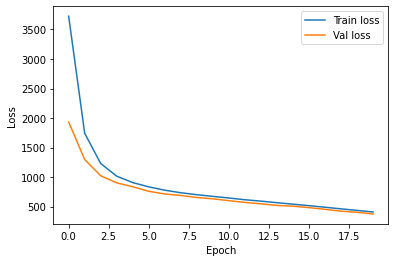

In [106]:
# Plot accuracy and loss
plt.figure()
plt.plot(train_loss_list, label='Train loss')
plt.plot(validation_loss_list, label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [123]:
model

AutoregressiveTransformer(
  (emb_i): Embeddings(
    (lut): Embedding(43, 128, padding_idx=0)
  )
  (emb_j): Embeddings(
    (lut): Embedding(43, 128, padding_idx=0)
  )
  (emb_edge_type): Embeddings(
    (lut): Embedding(10, 12, padding_idx=0)
  )
  (emb_i_size): Embeddings(
    (lut): Embedding(12, 16, padding_idx=0)
  )
  (emb_j_size): Embeddings(
    (lut): Embedding(12, 16, padding_idx=0)
  )
  (pos_emb): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (in_linear): Linear(in_features=300, out_features=256, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_

## Model Inference

In [144]:
def softmax_with_temperature(logits, temperature):
    probs = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature))
    return probs


def weighted_sampling(probs):
    probs /= sum(probs)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    word = np.random.choice(sorted_index, size=1, p=sorted_probs)[0]
    return word


# -- nucleus -- #
def nucleus(probs, p):
    probs /= (sum(probs) + 1e-5)
    sorted_probs = np.sort(probs)[::-1]
    sorted_index = np.argsort(probs)[::-1]
    cusum_sorted_probs = np.cumsum(sorted_probs)
    after_threshold = cusum_sorted_probs > p
    if sum(after_threshold) > 0:
        last_index = np.where(after_threshold)[0][0] + 1
        candi_index = sorted_index[:last_index]
    else:
        candi_index = sorted_index[:]
    candi_probs = [probs[i] for i in candi_index]
    candi_probs /= sum(candi_probs)
    word = np.random.choice(candi_index, size=1, p=candi_probs)[0]
    return word


def sampling(logit, p=None, t=1.0):
    logit = logit.squeeze().cpu().numpy()
    probs = softmax_with_temperature(logits=logit, temperature=t)
    
    if p is not None:
        cur_word = nucleus(probs, p=p)
    else:
        cur_word = weighted_sampling(probs)
    return cur_word

In [181]:
# TODO: Add Temperature

def predict(model, input_sequence, max_length=150):
    model.eval()
    
    SOS_token = (40, 40, 8, 10, 10)
    EOS_token = (41, 41, 9, 11, 11)
            
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        with torch.no_grad():
            # Get source mask
            tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

            y_i, y_j, y_edge_type, y_i_size, y_j_size = model(input_sequence, y_input, tgt_mask)

            # # sampling gen_cond
            # print(y_i.shape)
            # print(y_i[-1])
            curr_i = sampling(y_i[-1], t=0.5)
            cur_j = sampling(y_j[-1], t=0.5)
            cur_edge_type = sampling(y_edge_type[-1], t=2, p=0.8)
            cur_i_size = sampling(y_i_size[-1], t=0.25)
            cur_j_size = sampling(y_j_size[-1], t=0.25)

            # pred = []
            # for token in pred_tokens:
            #     next_item = token.topk(1)[1].view(-1)[-1].item() # num with highest probability
            #     pred.append(next_item)

            next_item = torch.tensor([[(curr_i, cur_j, cur_edge_type, cur_i_size, cur_j_size)]], device=device)
            # print(next_item)

            # Concatenate previous input with predicted best word
            y_input = torch.cat((y_input, next_item), dim=1)
            # print(y_input)

            # Stop if model predicts end of sentence
            # print(next_item.view(-1))
            # print(torch.tensor(EOS_token))
            if curr_i == torch.tensor(EOS_token[0]):
                break
    return y_input
    # return y_input.view(-1).tolist()

In [182]:
# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[(40, 40, 8, 10, 10)]], dtype=torch.long, device=device),
    torch.tensor([[(40, 40, 8, 10, 10), (1, 2, 1, 2, 4), (2, 3, 2, 4, 4)]], dtype=torch.long, device=device),
    torch.tensor([[(40, 40, 8, 10, 10), (1, 2, 1, 8, 7), (2, 3, 4, 7, 8)]], dtype=torch.long, device=device),
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example}")
    print(f"Continuation: {result}")
    # print()

Example 0
Input: tensor([[[40, 40,  8, 10, 10]]], device='cuda:0')
Continuation: tensor([[[40, 40,  8, 10, 10],
         [ 1,  2,  1,  4,  4],
         [ 2,  9,  3,  4,  4],
         [ 3,  4,  6,  4,  4],
         [ 3,  5,  3,  4,  4],
         [ 4,  5,  5,  4,  4],
         [ 4,  9,  3,  4,  4],
         [ 4, 10,  3,  4,  4],
         [ 4, 11,  3,  4,  4],
         [ 5,  6,  3,  4,  4],
         [ 5,  9,  3,  4,  4],
         [ 5, 10,  3,  4,  4],
         [ 5,  9,  3,  4,  4],
         [ 5, 10,  4,  4,  4],
         [ 5, 11,  3,  4,  4],
         [ 5,  7,  3,  4,  4],
         [ 5,  9,  3,  4,  4],
         [ 5, 10,  3,  4,  4],
         [ 5,  7,  3,  4,  4],
         [ 5,  9,  6,  4,  4],
         [ 5, 10,  3,  4,  4],
         [ 5, 15,  3,  4,  4],
         [ 6,  7,  3,  4,  4],
         [ 7,  9,  3,  4,  4],
         [ 7,  9,  3,  4,  4],
         [ 8,  9,  3,  4,  4],
         [ 8, 10,  3,  4,  4],
         [ 8, 10,  4,  4,  4],
         [ 9,  9,  6,  4,  4],
         [ 9, 10,  3